# Nystrom Tica aka Spectral-OASIS tutorial

Nystrom Tica is based on the Nyström matrix operation theory, which can approximately reconstruct the time-lagged covariance matrix of all input features while using only a subset of features as input. Given an initial input feature set, Spectral-oASIS samples a subset of these features that best reconstructs the leading eigenfunctions of the time lagged covariance matrix obtained from MD simulations

The end result of Nystrom tica is the same as Sparse Tica but nystrom tica uses different math to get there

Nystrom tica is implemented in PyEmma but it is missing from the documentation

see origonal paper here:

Litzinger, F.; Boninsegna, L.; Wu, H.; Nuske, F.; Patel, R.; Baraniuk, R.; Noe, F.; Clementi, C   
Rapid Calculation of Molecular Kinetics Using Compressed Sensing   
J. Chem. Theory Comput. 2018, 14 (5), 2771−2783   
https://pubs.acs.org/doi/10.1021/acs.jctc.8b00089?ref=PDF

Xuhui Huang spoke very highly of Nystrom tica. See how his lab uses it in their MSM workflow here:

Kirill A. Konovalov, Ilona Christy Unarta, Siqin Cao, Eshani C. Goonetilleke, and Xuhui Huang
Markov State Models to Study the Functional Dynamics of Proteins in the Wake of Machine Learning   
JACS Au 2021   
https://doi.org/10.1021/jacsau.1c00254

For this tutorial I will use the D.E Shaw main protease trajectory as a test system. All pairwize alpha carbon distances would be ~ 48,000 distances. Far to many to fit into memory.   

I will first load a set of all phi and psi dihedrals (1220 total) and see if I can reduce the number of distances while still keeping a high implied timescale   

Second I will see how many distances I can through at Nystrom tica before it crashes due to memory proplems   

For more details on the test system see:   
https://github.com/jgpattis/Desres-sars-cov-2-apo-mpro

In [41]:
import pyemma.coordinates as coor
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# load distance data I had already calculated and saved

data_path = '/media/tun37047/HD/tun37047/covid19/desres-protease/monomer_global_apo_msm'

data_a = coor.load(f'{data_path}/feature_data_02/backbone_chain_0.h5')
data_b = coor.load(f'{data_path}/feature_data_02/backbone_chain_1.h5')
data = data_a + data_b

The benifit of Nystrom tica is you let tica do the hard work of deciding which features are important   

I would recomend more general featurizations as input. Depending on your system size things like all pairwize heavy atom distances, all pairwize alpha carbon and beta carbon distances, or all all pairwize alpha carbon distances   

for examples of these featurizations see:   
https://github.com/vvoelz/msm-best-practices/wiki/03-Featurization   
or the PyEmma tutorial

In [30]:
# Here I am workin with 200 trajectories
len(data)

200

In [189]:
# Each trajectory is 1 microsecond long (1000 frames) with
#   1 ns between frames and 1220 features(sin and cos products of backbone phi and psi dihedral angles)
data[0].shape

(1000, 1220)

Nystrom tica is not in the PyEmma documentation   
so to look at the inputs and outputs look at the PyEmma github:   
https://github.com/markovmodel/PyEMMA/blob/devel/pyemma/coordinates/transform/nystroem_tica.py#L51   

or alternativly print the doc string

In [35]:
# The docstring is long so use prnt to format it nice
print(coor.tica_nystroem.__doc__)

 Sparse sampling implementation [1]_ of time-lagged independent component analysis (TICA) [2]_, [3]_, [4]_.

    Parameters
    ----------
    max_columns : int
        Maximum number of columns (features) to use in the approximation.
    data : ndarray (T, d) or list of ndarray (T_i, d) or a reader created by
        source function array with the data. With it, the TICA
        transformation is immediately computed and can be used to transform data.
    lag : int, optional, default 10
        lag time
    dim : int, optional, default -1
        Maximum number of significant independent components to use to reduce dimension of input data. -1 means
        all numerically available dimensions (see epsilon) will be used unless reduced by var_cutoff.
        Setting dim to a positive value is exclusive with var_cutoff.
    var_cutoff : float in the range [0,1], optional, default 0.95
        Determines the number of output dimensions by including dimensions until their cumulative kineti

These options are very similar to regular tica except:   

max_columns: How many features to use. I would recomend making an informed decision by plotting different options vs implied timescale (shown below)   

nsel: How many columns to scan through at once. The origonal paper uses 20. The lower nsel is the better the tica approximation should be but the longer the calculation takes. As seen below larger numbers here work well

In [116]:
start = time.time()
Ntica = coor.tica_nystroem(max_columns=200, data=data, lag=15, nsel=10)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 45.0 seconds


In [117]:
start = time.time()
Ntica_20 = coor.tica_nystroem(max_columns=200, data=data, lag=15, nsel=20)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 27.0 seconds


In [118]:
start = time.time()
Ntica_30 = coor.tica_nystroem(max_columns=200, data=data, lag=15, nsel=30)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 22.0 seconds


Text(0, 0.5, 'Timescale (ns)')

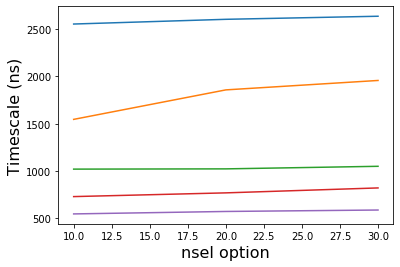

In [119]:
fig, ax = plt.subplots()
nsel_list = [10, 20, 30]
tica_trials = [Ntica, Ntica_20, Ntica_30]
for i in range(5): # lets look at top 5 timescales
    temp = [k.timescales[i] for k in tica_trials]
    ax.plot(nsel_list, temp, label=f'ts {i + 1}')
ax.set_xlabel('nsel option', fontsize=16)
ax.set_ylabel('Timescale (ns)', fontsize=16)

in the above, implied timescales go up with increasing nsel, which is the opposite of what I was expecting, and I believe the opposite of what it should be.   

I believe this means that would could keep increasing nsel for a nice speedup of the calculation without loss of accuracy

I will learn later that larger values of max_columns also slows down the calculation

In [185]:
# Larger numbers of nsel affects the resolution of max_columns
print(f'Features in Ntica, Ntica_20, Ntica_30: {len(Ntica.column_indices)} {len(Ntica_20.column_indices)} {len(Ntica_30.column_indices)}')

Features in Ntica, Ntica_20, Ntica_30: 201 201 211


In [120]:
# Ok now lets look at the tica components
Ntica_30.get_output()

ValueError: shapes (1000,1220) and (211,82) not aligned: 1220 (dim 1) != 211 (dim 0)

So Nystrom tica is refusing to give me the tica components it calculated. I tried lots of different options and was unable to figure out what was going wrong. This is really bad but I will show a work around later   

Next lets make a plot of implied timescales vs max_columns to make an informed decision on how sparce we can go

In [131]:
# I would recommend exponetial scaling for column list
column_list = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 700, 900]
out_list = []
true_column_list = []
start = time.time()

for i in column_list:
    temp_ntica = coor.tica_nystroem(max_columns=i, data=data, lag=15, nsel=30)
    out_list.append(temp_ntica.timescales)
    true_column_list.append(len(temp_ntica.column_indices))
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 441.0 seconds


In [132]:
reg_tica = coor.tica(data, lag=15)
out_list.append(reg_tica.timescales)

In [133]:
column_list.append(1220) # full number of features
true_column_list.append(1220)

In [135]:
# The true number of columns is not what I input for max_columns
# instead it is around max_columns
true_column_list

[31, 31, 61, 91, 121, 151, 211, 271, 301, 421, 511, 721, 901, 1220]

Text(0, 0.5, 'Timescale (ns)')

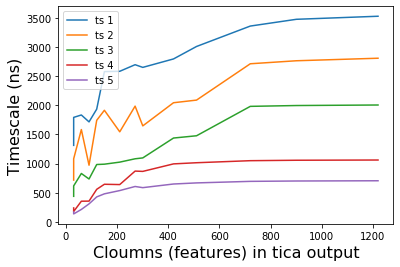

In [136]:
fig, ax = plt.subplots()
for i in range(5):  # plot the top i number of timescales
    temp = [out_list[k][i] for k in range(len(out_list))]
    ax.plot(true_column_list, temp, label=f'ts {i +1}')
ax.legend()
ax.set_xlabel('Cloumns (features) in tica output', fontsize=16)
ax.set_ylabel('Timescale (ns)', fontsize=16)

In the apove plot implied timescales increase with increasing numbers of features. From this we can make a decison on how much 'information' we are willing to loose to make tica simpliar and easier to interpret. These two things area tradeoff one for the other.   

In this plot I personally see two good choices:

721 features: (aka the free lunch) at 721 features there is a very tiny decrease in timescales from regular (full) tica. With this option we would reduce the number of features by 43% while loosing very little kinetic information (we still describe the motions in the main protease very well). This is what the theory paper suggests a optimal, that you look for the asymptote of the curve   

421 features: (aka the compromize) at 421 features there is a signifigent decrease in timescae of the first three tICs, but it's not quite as dramatic as lower than 400 features. This is a happy medium where we are not describing the motions quite as well as we could be but that allows for a 67% reduction in features

Lower that 421 features in my opinion is a bad option as too much kenitic information is lost

See the two publications I cite at the top of this tutorial for more examples

Your results may vary, but this plot helps you make an informed decision

In [126]:
# ok now lets figure out how to actually get tica components
# run nystrom tica with the optimum output of 700 features
start = time.time()
Ntica_700 = coor.tica_nystroem(max_columns=700, data=data, lag=15, nsel=30)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 82.0 seconds


In [127]:
print(f'This took {np.round(end-start)} seconds')

This took 82.0 seconds


notice that moving from a max_columns of 200 to 700 slowed down the calculation from 22 seconds to 82 seconds

In [129]:
# this object contains a column_indices attribute which gives
#  the index of the columns retained
Ntica_700.column_indices.shape

(721,)

In [130]:
# interesting that it isn't exactly 700??
# Maybe I should be plotting against column_indices
# but anyway, lets now filter my origonal dataset
Ntica_700.column_indices

array([ 301,  174,  178,  183,  185,  186,  187,  191,  194,  196,  199,
        284,  302,  311,  545,  554,  572,  574,  612,  613,  615,  770,
        776,  786,  791,  899, 1202, 1203, 1206, 1214, 1218,    1,    6,
        172,  177,  179,  182,  184,  188,  197,  198,  206,  552,  558,
        561,  566,  754,  760,  762,  764,  780,  784,  896, 1196, 1198,
       1199, 1201, 1204, 1210, 1211, 1215,  168,  175,  176,  180,  189,
        190,  195,  548,  556,  560,  562,  610,  616,  752,  755,  768,
        772,  773,  788,  862,  876,  887, 1101, 1192, 1197, 1200, 1207,
       1208, 1212, 1219,    0,    4,   92,  171,  181,  202,  210,  236,
        260,  287,  296,  304,  309,  516,  532,  551,  563,  564,  604,
        619,  774,  775,  779,  787,  884,  888, 1103, 1106, 1195, 1216,
          7,   88,   95,  192,  207,  239,  240,  243,  280,  315,  318,
        387,  536,  568,  571,  669,  676,  732,  735,  782,  880,  924,
        931, 1095, 1096, 1098, 1100, 1104, 1108, 12

In [143]:
# go through your list of trajectories and filter each one by our new set of features
filtered_data = [i[:,Ntica_700.column_indices] for i in data]

In [138]:
data[0].shape

(1000, 1220)

In [142]:
# the first dimentions is frames
# the second dimention is features
# check to make sure you filtered along the correct dimention
filtered_data[0].shape

(1000, 721)

In [158]:
# I have not loaded my PyEmma featurizer object at the biginning because I did this earlier and saved it
# but you could filter your feature discription so you know what these features are

pdb = f'{data_path}/DESRES_protease_chainid.pdb'
''' Bachbone Phi and Psi torsion angles '''
featurizer = coor.featurizer(pdb)
featurizer.add_backbone_torsions(cossin=True, selstr=f'chainid == 0')
featurizer.describe()[:20]

['COS(PHI 0 GLY 2)',
 'SIN(PHI 0 GLY 2)',
 'COS(PSI 0 SER 1)',
 'SIN(PSI 0 SER 1)',
 'COS(PHI 0 PHE 3)',
 'SIN(PHI 0 PHE 3)',
 'COS(PSI 0 GLY 2)',
 'SIN(PSI 0 GLY 2)',
 'COS(PHI 0 ARG 4)',
 'SIN(PHI 0 ARG 4)',
 'COS(PSI 0 PHE 3)',
 'SIN(PSI 0 PHE 3)',
 'COS(PHI 0 LYS 5)',
 'SIN(PHI 0 LYS 5)',
 'COS(PSI 0 ARG 4)',
 'SIN(PSI 0 ARG 4)',
 'COS(PHI 0 MET 6)',
 'SIN(PHI 0 MET 6)',
 'COS(PSI 0 LYS 5)',
 'SIN(PSI 0 LYS 5)']

In [162]:
new_discriptions = [featurizer.describe()[i] for i in Ntica_700.column_indices]

In [164]:
# now we know which features were included
new_discriptions[:20]

['SIN(PHI 0 VAL 77)',
 'COS(PSI 0 CYS 44)',
 'COS(PSI 0 THR 45)',
 'SIN(PSI 0 SER 46)',
 'SIN(PHI 0 ASP 48)',
 'COS(PSI 0 GLU 47)',
 'SIN(PSI 0 GLU 47)',
 'SIN(PSI 0 ASP 48)',
 'COS(PSI 0 MET 49)',
 'COS(PHI 0 ASN 51)',
 'SIN(PSI 0 LEU 50)',
 'COS(PHI 0 VAL 73)',
 'COS(PSI 0 ARG 76)',
 'SIN(PSI 0 ILE 78)',
 'SIN(PHI 0 GLY 138)',
 'COS(PSI 0 SER 139)',
 'COS(PHI 0 CYS 145)',
 'COS(PSI 0 SER 144)',
 'COS(PHI 0 ASP 155)',
 'SIN(PHI 0 ASP 155)']

In [165]:
# now lets put the filtered dataset into regular tica

regular_tica_700 = coor.tica(filtered_data, lag=15, kinetic_map=False, commute_map=True, var_cutoff=0.85)

In [166]:
tica_output = regular_tica_700.get_output()

In [167]:
# Success
# you can now plot this and cluster this
tica_output

[array([[ 7.2529650e+00,  3.1823325e+00, -1.8030664e+01, ...,
          5.7500231e-01, -5.6733173e-01,  1.6304612e+00],
        [ 8.9555311e+00,  1.9138721e+00, -1.8332710e+01, ...,
         -8.6346447e-01, -1.7985759e-02,  3.8923344e-01],
        [ 8.9435415e+00,  1.3724555e+00, -1.5595529e+01, ...,
         -3.7557549e+00,  8.0296612e-01,  2.9753759e+00],
        ...,
        [ 8.4371319e+00,  3.7780395e+00, -1.4112538e+01, ...,
         -1.7101835e+00,  1.6008937e+00, -2.4026592e+00],
        [ 9.4091387e+00,  4.3223815e+00, -1.3392380e+01, ...,
         -1.8444209e+00,  1.9194384e+00, -2.6768992e+00],
        [ 8.9067278e+00,  4.6855865e+00, -1.4793872e+01, ...,
         -7.2750491e-01,  7.1574754e-01, -2.8617460e-01]], dtype=float32),
 array([[  9.804038  ,   4.0855603 , -16.093567  , ...,   0.6509474 ,
           2.1703503 ,  -3.5682626 ],
        [  7.1936936 ,   4.114812  , -13.483134  , ...,   1.497254  ,
           2.1939027 ,  -2.0190985 ],
        [  8.50223   ,   0.8125593

Text(0, 0.5, 'IC 2')

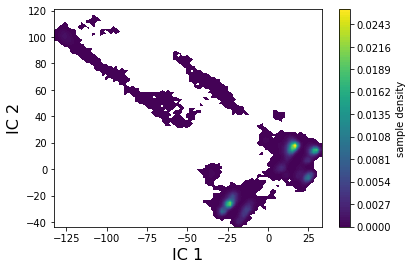

In [170]:
# let's make a nice plot because we can
from pyemma.plots import plot_density

cat_output = np.concatenate(tica_output)

fig, ax, cb = plot_density(cat_output[:,0], cat_output[:,1])
ax.set_xlabel('IC 1', fontsize=16)
ax.set_ylabel('IC 2', fontsize=16)

Everything done so far could also be done with sparse tica (avialable in MSMBuilder)

One downside of Tica and Sparse Tica is that they require N_features^3 memory. Sparse Tica makes the full covariance matrix then kicks features out to find a sparse solution. Nystrom tica builds the covariance matrix a little bit at a time and should in theory be able to handle more features.

Regular tica will crash on this computer (with 128 GB of RAM) at ~9000 features. Let's see how high Nystrom tica can go

# Warning!! The next section may crash your computer, save anything important, and procede at your own risk ... or better yet just look at my results and don't do this

In [174]:
# Let's use pairwize CA distances
traj_num = [f'{i:04d}' for i in range(100)] 
traj_path = '/../DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA/sarscov2-10880334-no-water-no-ion-glueCA/sarscov2-10880334-no-water-no-ion-glueCA-'
traj_list = [ data_path + traj_path + str(i) + '.dcd' for i in traj_num]

feat = coor.featurizer(pdb)
feat.add_distances(feat.pairs(feat.select('name == CA and chainid == 0'), excluded_neighbors=3))
traj = coor.load(traj_list, feat, stride=5)
traj_cat = np.concatenate(traj)

In [187]:
# working with source also helps minimize RAM usage
# NOTE: I later find out that source does not imporve anyting
#  since Nystrom tica needs all data in memory.
traj_source = coor.source(traj_list, feat, stride=5)

In [177]:
# 46,000 distances !!!
traj[0].shape

(200, 46665)

In [178]:
# Let's start with 15,000
data_15 = [i[:,:15000] for i in traj]

In [179]:
# Let's see what happens
start = time.time()
Ntica_big = coor.tica_nystroem(max_columns=700, data=data_15, lag=15, nsel=100)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

This took 1342.0 seconds


In [182]:
print(f'This took {np.round((end-start)/60)} minutes')

This took 22.0 minutes


In [186]:
# Let's go for broke
# use source instead of load to save memory
start = time.time()
Ntica__really_big = coor.tica_nystroem(max_columns=2000, data=traj_source, lag=15, nsel=400)
end = time.time()
print(f'This took {np.round(end-start)} seconds')

02-09-21 10:46:21 pyemma.coordinates.transform.nystroem_tica.NystroemTICA[245] WARNING  Every iteration of the selection process involves streaming of all data and featurization. Depending on your setup, this might be inefficient.


KeyboardInterrupt: 

Ok so the above ran for 24 hours without crashing so I think it will work I just didn't want to wain for it.

Also note that PyEmma through a warning that Nystrom Tica needs to load all data into memory so using source didn't help save memeory

In [188]:
len(Ntica_big.column_indices)

701

# Conclustion

Nystrom tica was able to greatly reduce reduce the number of features in the Main Protease system while still describing the slow motions basically as well as regular tica

making a plot of implied timescales vs the number of column indices (with len(Ntica.column_indices) helps you make an informed decision of how sparse you can go

It was also shown that Nystrom tica can be fed extremly large numbers of features and still work

larger numbers for nsel and smaller numbers for max_columns greatly speed up the calculation

The fact that Nystrom tica has still not been added to the PyEmma manual and that the get_output() method is broken is very concerning. It is possible the PyEmma developers are not activly maintaining the code